In [45]:
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),1*Matern()+1*WhiteKernel(noise_level=0.5)]


dataDir = Path.cwd().parent.parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"ts_dataset_58_with_cat.csv", index_col="id")

In [46]:
X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=10)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

Mean cross-validated score of the best_estimator:  0.9883040935672516
Best estimator parameters:  {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.890 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.977 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.988 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.977 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.988 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


d:\Toolbox\python\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
#best_kernel = 1*DotProduct()
best_kernel = 1*Matern()

model_ini = GaussianProcessClassifier(kernel=best_kernel, random_state=10, n_jobs=-1, optimizer=None)
model_ini.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model_ini.score(X_train, y_train))

model_opt = GaussianProcessClassifier(kernel=best_kernel, random_state=8, n_jobs=-1)
model_opt.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model_opt.score(X_train, y_train))


print(
    "Log Marginal Likelihood: %.3f"
    % model_ini.log_marginal_likelihood(model_ini.kernel_.theta)
)
print(
    "Log Marginal Likelihood: %.3f"
    % model_opt.log_marginal_likelihood(model_opt.kernel_.theta)
)

print(
    "Log-loss: %.3f (initial) %.3f (optimized)"
    % (
        log_loss(y_train, model_ini.predict_proba(X_train)[:, 1]),
        log_loss(y_train, model_opt.predict_proba(X_train)[:, 1]),
    )
)

model_opt.predict_proba


Mean accuracy on training data:  1.0
Mean accuracy on training data:  1.0
Log Marginal Likelihood: -30.127
Log Marginal Likelihood: -14.503
Log-loss: 0.537 (initial) 0.212 (optimized)


<bound method GaussianProcessClassifier.predict_proba of GaussianProcessClassifier(kernel=1**2 * Matern(length_scale=1, nu=1.5),
                          n_jobs=-1, random_state=8)>

[Text(0.5, 1.0, 'GPC-Matern-Train'),
 Text(0.5, 0, 'Predicted probability(positive class)'),
 Text(0, 0.5, 'Count')]

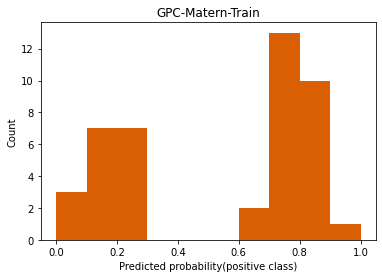

In [42]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
colors = plt.cm.get_cmap("Dark2")

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(
    model_opt.predict_proba(X_train)[:,1],
    range=(0, 1),
    bins=10,
    label="GP",
    color=colors(1),
    )
ax.set(title="GPC-Matern-Train", xlabel="Predicted probability(positive class)", ylabel="Count")

In [19]:
model_opt.predict_proba(X_train)[:,0]

array([[0.79832197, 0.20167803],
       [0.80557327, 0.19442673],
       [0.19790541, 0.80209459],
       [0.29276125, 0.70723875],
       [0.22264224, 0.77735776],
       [0.82838571, 0.17161429],
       [0.82771511, 0.17228489],
       [0.76901952, 0.23098048],
       [0.72286765, 0.27713235],
       [0.81627276, 0.18372724],
       [0.82149059, 0.17850941],
       [0.24077357, 0.75922643]])

In [32]:
#best_kernel = 1*DotProduct()
best_kernel = 1*Matern()
model = GaussianProcessClassifier(kernel=best_kernel, random_state=8, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  1.0
Prediction on test data:  [1 1 0 1 1 1 1 1 1 1 0 0 1 0 1]
Prediction accuracy on test data:  1.0


In [40]:
model.predict_proba(X_test)



array([[0.14069001, 0.85930999],
       [0.20829313, 0.79170687],
       [0.5866263 , 0.4133737 ],
       [0.4752918 , 0.5247082 ],
       [0.28963218, 0.71036782],
       [0.17827066, 0.82172934],
       [0.2025179 , 0.7974821 ],
       [0.15667253, 0.84332747],
       [0.12335449, 0.87664551],
       [0.1373424 , 0.8626576 ],
       [0.75141791, 0.24858209],
       [0.93980368, 0.06019632],
       [0.34514434, 0.65485566],
       [0.64332464, 0.35667536],
       [0.24495825, 0.75504175]])

[Text(0.5, 1.0, 'GPC-Matern-Test'),
 Text(0.5, 0, 'Predicted probability(positive class)'),
 Text(0, 0.5, 'Count')]

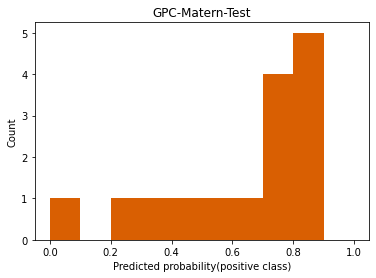

In [41]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
colors = plt.cm.get_cmap("Dark2")

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(
    model.predict_proba(X_test)[:,1],
    range=(0, 1),
    bins=10,
    label="GP",
    color=colors(1),
    )
ax.set(title="GPC-Matern-Test", xlabel="Predicted probability(positive class)", ylabel="Count")

In [36]:
ts_dataset

,"timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2",...,timeDelta_Seconds__quantile__q_0.8,timeDelta_Seconds__quantile__q_0.7,"timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",timeDelta_Seconds__mean_abs_change,"timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4",timeDelta_Seconds__mean,BreedName_1,BreedName_2,BreedName_4,label
id,,,,,,,,,,,,,,,,,,,,,
1,-0.892543,-1.967178,-1.864354,-2.005686,-0.939033,-1.813592,-1.294771,-1.111943,-1.158618,-1.073848,...,-1.095250,-1.056712,-1.224945,-1.967178,-1.034363,-0.982661,1.0,0.0,0.0,0
2,-0.368274,-0.095543,-0.333365,-0.040805,-0.412923,-0.552221,-0.274979,-0.532136,-0.775876,-0.425686,...,-0.511132,-0.626362,-0.387532,-0.095543,-0.413100,-0.559507,0.0,1.0,0.0,0
3,0.474841,1.281555,0.592292,0.280721,0.538522,1.111727,0.257960,0.834284,1.095254,0.498651,...,1.299679,1.395223,0.536108,1.281555,0.393414,1.787649,1.0,0.0,0.0,1
4,0.709707,1.195803,1.005099,0.994186,1.166862,1.683797,1.307773,1.552361,1.180452,0.945346,...,1.701406,1.782827,1.770966,1.195803,0.795727,1.766106,0.0,0.0,1.0,1
5,-0.708845,-0.478761,-0.627179,-0.629481,-0.759835,-0.471325,-0.785756,-0.640556,-0.946368,-0.753154,...,-0.632258,-0.426453,-0.790245,-0.478761,-0.653210,-0.238047,0.0,1.0,0.0,0
6,0.234937,0.337581,0.375677,0.196194,0.094586,0.390421,0.110778,0.158206,0.391069,0.211301,...,0.413916,0.409178,0.305719,0.337581,0.189125,0.428731,0.0,1.0,0.0,1
7,-0.552449,-0.633140,-0.500709,-0.477285,-0.556826,-0.516984,-0.632304,-0.576422,-0.605416,-0.514072,...,-0.732339,-0.544406,-0.497241,-0.633140,-0.547924,-0.899945,1.0,0.0,0.0,0
8,3.304686,1.867304,2.631367,1.934144,3.095905,2.215864,2.141279,2.843172,2.472536,3.196588,...,2.083023,2.304775,2.171732,1.867304,3.273493,1.745489,0.0,1.0,0.0,1
9,-0.630273,-0.675077,-0.534787,-0.564429,-0.612738,-0.416007,-0.753608,-0.555778,-0.543829,-0.576715,...,-0.753384,-0.493946,-0.869843,-0.675077,-0.592715,-0.691563,1.0,0.0,0.0,0


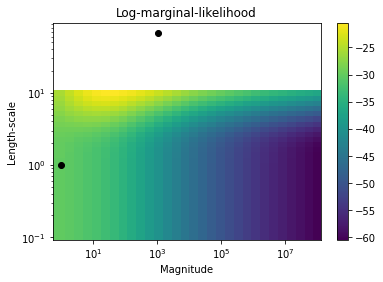

In [44]:
# Plot LML landscape
plt.figure()
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [
    [
        model_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])
    ]
    for j in range(Theta0.shape[1])
]
LML = np.array(LML).T
plt.plot(
    np.exp(model_ini.kernel_.theta)[0], np.exp(model_ini.kernel_.theta)[1], "ko", zorder=10
)
plt.plot(
    np.exp(model_opt.kernel_.theta)[0], np.exp(model_opt.kernel_.theta)[1], "ko", zorder=10
)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()